In [1]:
import numpy as np
import os
import sys

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result

In [2]:
# Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = 0.05 #m2

r_xi = -111.76 * 10 ** (-3)
r_zi = 0.722 * 10 ** (-3)

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10 ** (-3)
r_zt = -35.18 * 10 ** (-3)

rho = 1000

# Aero foil parameters
AR = 2.61 #aspect ratio
area = 0.025 #Surface area
C_L_a = 1
C_L_alpha_offset = 0.5
C_D_0 = 0.02



In [3]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),AR,area,C_L_a,C_L_alpha_offset,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])



In [4]:
pitch_angle = -6
initial_state=np.array([0, 0, 0, 2, 0, 0, 0, 0, 0])
sim.initialize_system(initial_state)
# Solve forces
sim.solve_forces(0)

# Calculate sum of forces/moments
total_force_x, total_force_z = sim.rigidbody.sum_forces(pitch_angle) 
total_moment_y = sim.rigidbody.sum_moments(pitch_angle)

print(total_force_x)
print(total_force_z)
print(total_moment_y)

-79.36616503594436
-47.202312947760504
-2.5913465421534196


In [5]:
print(controlForce.magnitude)

[ 2.26895891 21.02874885]


In [6]:
print(hullForce.magnitude)

[90.  0.]


In [7]:
# results = sim.solve_equilibrium_state_fsolve_fixed_delta_i(2, 5)
# results = sim.solve_equilibrium_state_fsolve_fixed_pitch(5, -6)


In [14]:
#Find equilibrium by minimizing 3D vector of Forces and moment
results = sim.solve_equilibrium_state_sqrt(2)

#Solve forward euler
#initial_state = np.array([0, 0, results.x[0], 2, 0, 0, 0, 0, 0]) #Set pitch angle to equilibrium value
#sim.sim = sim.simulate_forward_euler(1000,0.01,initial_state)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     6.99            degrees   
Delta_t         0.00            degrees   
Towing Force    92.15           N         
Delta_i         -20.00          degrees   
----------------------
Fx constraint   0.72            N         
Fz constraint   -7.45           N         
My constraint   -4.72           Nm        
Objective Function Value: 78.33114892971035
Optimization successful!


In [9]:
#Find equilibrium by constraining forces/moment to zero and solve for minimum towing force
results = sim.solve_equilibrium_state_min_FT(2)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 35.23462950164766
            Iterations: 8
            Function evaluations: 28
            Gradient evaluations: 4
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -8.00           degrees   
Delta_t         14.12           degrees   
Towing Force    35.23           N         
Delta_i         -20.00          degrees   
----------------------
Fx constraint   -57.52          N         
Fz constraint   -8.46           N         
My constraint   -1.60           Nm        
Optimization failed: Positive directional derivative for linesearch


In [10]:
#Find equilibrium by minimizing Forces and moment individually using least squares
results = sim.solve_equilibrium_state_LS(2)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -8.00           degrees   
Delta_t         0.00            degrees   
Towing Force    89.85           N         
Delta_i         -20.00          degrees   
----------------------
Fx:             -1.19          N         
Fz:             -7.70          N         
My:             -3.61          Nm        
Residual Norm: 36.856858
Optimization successful!


Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -7.01           degrees   
Delta_t         0.00            degrees   
Towing Force    90.01           N         
Delta_i         -20.00          degrees   
----------------------
Fx:             -1.06          N         
Fz:             -7.72          N         
My:             -3.69          Nm        
Residual Norm: 37.136290
Optimization successful!
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -5.45           degrees   
Delta_t         0.00            degrees   
Towing Force    90.25           N         
Delta_i         -20.00          degrees   
----------------------
Fx:             -0.86          N         
Fz:             -7.73          N         
My:             -3.81          Nm        
Residual Norm: 37.540169
Optimization successful!
Optimization Results:
--------------

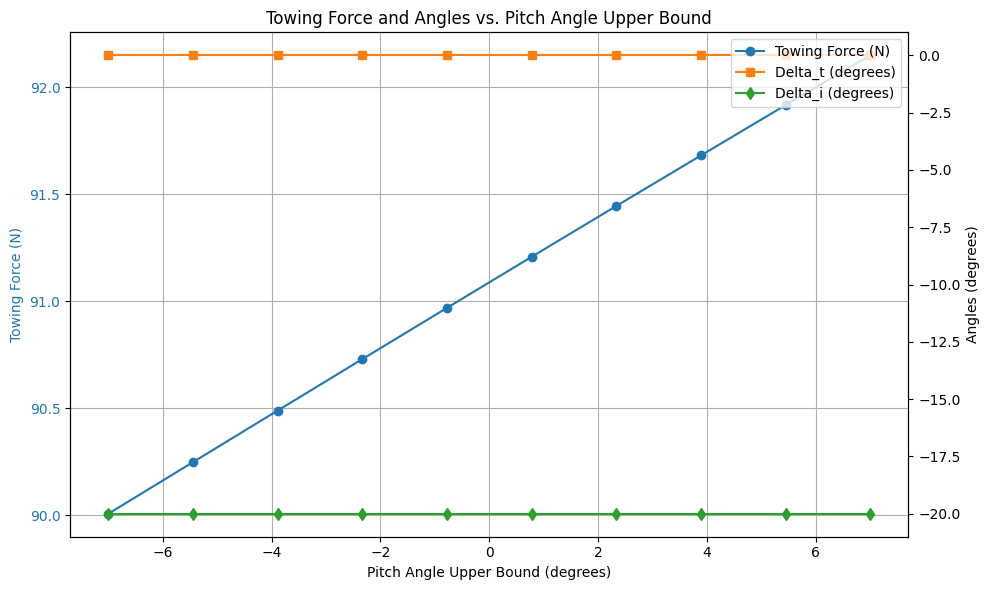

In [11]:
import matplotlib.pyplot as plt

# Generate pitch angle upper bounds (in radians)
pitch_angle_upper_bounds = np.linspace(-7, 7, 10)  # 10 points from -7 to 7 degrees

# Initialize arrays for results
towForces = np.zeros_like(pitch_angle_upper_bounds)
delta_ts = np.zeros_like(pitch_angle_upper_bounds)
delta_is = np.zeros_like(pitch_angle_upper_bounds)

# Run the simulation for each upper bound
for i, pitch_angle_ub in enumerate(pitch_angle_upper_bounds):
    sim.ub_pitch_angle = np.deg2rad(pitch_angle_ub)  # Convert to radians
    sim.lb_pitch_angle = np.deg2rad(pitch_angle_ub - 0.01)  # Lower bound in radians
    sim.bounds[0] = (sim.lb_pitch_angle, sim.ub_pitch_angle)
    result_LS = sim.solve_equilibrium_state_LS(2)  # Simulate and retrieve results

    # Store results
    delta_ts[i] = np.rad2deg(result_LS[1])  # Convert to degrees
    towForces[i] = result_LS[2]  # Force in N
    delta_is[i] = np.rad2deg(result_LS[3])  # Convert to degrees

# Create the figure and twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot towing force on the primary y-axis
ax1.plot(pitch_angle_upper_bounds, towForces, 'o-', color='tab:blue', label='Towing Force (N)')
ax1.set_xlabel('Pitch Angle Upper Bound (degrees)')
ax1.set_ylabel('Towing Force (N)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot delta_t and delta_i on the secondary y-axis
ax2.plot(pitch_angle_upper_bounds, delta_ts, 's-', color='tab:orange', label='Delta_t (degrees)')
ax2.plot(pitch_angle_upper_bounds, delta_is, 'd-', color='tab:green', label='Delta_i (degrees)')

ax2.set_ylabel('Angles (degrees)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout and show the plot
plt.title('Towing Force and Angles vs. Pitch Angle Upper Bound')
plt.tight_layout()
plt.show()
